In [1]:
import sys
import datetime as dt
import pandas as pd
import numpy as np
import scipy.stats  as stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../')
from envir import config

/home/cusp/yg833/.conda/envs/birdsVE3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1. Load Data

In [2]:
df = pd.read_csv(config.dataFol+'all_cleaned_wsp_sonyc_birds_by_hour.csv')

### 2. Processing Data
* convert timestamps from UTC to US/Eastern

In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp_utc']) \
    .dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
df['year'] = pd.DatetimeIndex(df['timestamp']).year
df['month'] = pd.DatetimeIndex(df['timestamp']).month
df['day'] = pd.DatetimeIndex(df['timestamp']).day
df['hour'] = pd.DatetimeIndex(df['timestamp']).hour

In [4]:
df.shape

(756880, 33)

In [5]:
df.head()

timestamp_utc sonyc_sensor_id           sonyc_sensor_name  \
0  2017-03-02 07:00    b827eb815321  19 Washington Square North   
1  2017-03-02 07:00    b827eb0fedda                 Juan Carlos   
2  2017-03-02 07:00    b827eb1685c7        Shimkin Reading Room   
3  2017-03-02 07:01    b827eb815321  19 Washington Square North   
4  2017-03-02 07:01    b827eb0fedda                 Juan Carlos   

   dBAS_lin_mean       l1     l10         l5     l90  \
0      59.166330  66.6600  64.664  65.864500  52.550   
1      53.477207  61.8205  53.870  55.319000  51.549   
2      61.856247  70.3921  63.218  68.984000  58.510   
3      57.641624  65.6847  61.611  63.781998  52.209   
4      60.136166  68.6936  64.030  67.075000  52.408   

   count_of_positive_predictions  pct_positive_predictions  ...  \
0                            0.0                   0.04918  ...   
1                            0.0                   0.03333  ...   
2                            0.0                   0.00000  ...   
3                            0.0                   0.04918  ...   
4                            0.0                   0.03333  ...   

   s_19WashingtonSquareNorth  s_juanCarlos  s_shimkinReadingRoom  \
0                          1             0                     0   
1                          0             1                     0   
2                          0             0                     1   
3                          1             0                     0   
4                          0             1                     0   

   s_4WashingtonSquareNorth  s_kimmelCenter                 timestamp  year  \
0                         0               0 2017-03-02 02:00:00-05:00  2017   
1                         0               0 2017-03-02 02:00:00-05:00  2017   
2                         0               0 2017-03-02 02:00:00-05:00  2017   
3                         0               0 2017-03-02 02:01:00-05:00  2017   
4                         0               0 2017-03-02 02:01:00-05:00  2017   

   month  day  hour  
0      3    2     2  
1      3    2     2  
2      3    2     2  
3      3    2     2  
4      3    2     2  

[5 rows x 33 columns]

In [6]:
df.dtypes

timestamp_utc                                        object
sonyc_sensor_id                                      object
sonyc_sensor_name                                    object
dBAS_lin_mean                                       float64
l1                                                  float64
l10                                                 float64
l5                                                  float64
l90                                                 float64
count_of_positive_predictions                       float64
pct_positive_predictions                            float64
avg_mtr_#/km/h                                      float64
avg_mt_#/km                                         float64
avg_height_m                                        float64
temp_celcius                                        float64
dewp_celcius                                        float64
rh_percentage                                       float64
wind_dir                                

In [7]:
df.sonyc_sensor_name.unique()

array(['19 Washington Square North', 'Juan Carlos',
       'Shimkin Reading Room', '4 Washington Square North',
       'Kimmel Center'], dtype=object)

In [8]:
df.shape

(756880, 33)

### 3. Examining YAMNet Data
* find the sonyc sensor name for easy comprehension


In [9]:
yamnetByHour = df[['sonyc_sensor_name', 'pct_positive_predictions',
                       'year', 'month', 'day', 'hour']].drop_duplicates()
yamnetByHour = yamnetByHour[(yamnetByHour.month >=3) & (yamnetByHour.month <=5)]
yamnetByHour['year'] = yamnetByHour.year.astype(str)
yamnetByHour['month'] = yamnetByHour.month.apply(lambda x: '{0:0>2}'.format(x))
yamnetByHour['day'] = yamnetByHour.day.apply(lambda x: '{0:0>2}'.format(x))
yamnetByHour['hour'] = yamnetByHour.hour.apply(lambda x: '{0:0>2}'.format(x))
yamnetByHour['datetime'] = yamnetByHour['year']+'-'+yamnetByHour['month']+ \
    '-'+yamnetByHour['day']+' '+yamnetByHour['hour']+':00'
yamnetByHour['datetime'] = pd.to_datetime(yamnetByHour.datetime)
yamnetByHour.head()

sonyc_sensor_name  pct_positive_predictions  year month day  \
0    19 Washington Square North                   0.04918  2017    03  02   
1                   Juan Carlos                   0.03333  2017    03  02   
2          Shimkin Reading Room                   0.00000  2017    03  02   
188  19 Washington Square North                   0.00000  2017    03  02   
189                 Juan Carlos                   0.00000  2017    03  02   

    hour            datetime  
0     02 2017-03-02 02:00:00  
1     02 2017-03-02 02:00:00  
2     02 2017-03-02 02:00:00  
188   03 2017-03-02 03:00:00  
189   03 2017-03-02 03:00:00

### 4. pct_positive_predictions by sensor by month by hour

In [10]:
yamnetMonthly = yamnetByHour.groupby(['sonyc_sensor_name','year','month','hour']) \
    .agg(['mean', 'std']).reset_index()
yamnetMonthly['hour_est'] = yamnetMonthly.hour.astype(float)
yamnetMonthly.columns = ["_".join(x) for x in yamnetMonthly.columns.ravel()]
yamnetMonthly.rename(columns={'sonyc_sensor_name_':'sensor', 'year_':'year', 
                             'month_':'month', 'hour_est_':'hour_est',
                             'hour_':'hour'}, inplace=True)
yamnetMonthly.head()

sensor  year month hour  pct_positive_predictions_mean  \
0  19 Washington Square North  2017    03   00                       0.000000   
1  19 Washington Square North  2017    03   01                       0.012262   
2  19 Washington Square North  2017    03   02                       0.020446   
3  19 Washington Square North  2017    03   03                       0.028890   
4  19 Washington Square North  2017    03   04                       0.042116   

   pct_positive_predictions_std  hour_est  
0                      0.000000       0.0  
1                      0.033909       1.0  
2                      0.029078       2.0  
3                      0.038859       3.0  
4                      0.044732       4.0

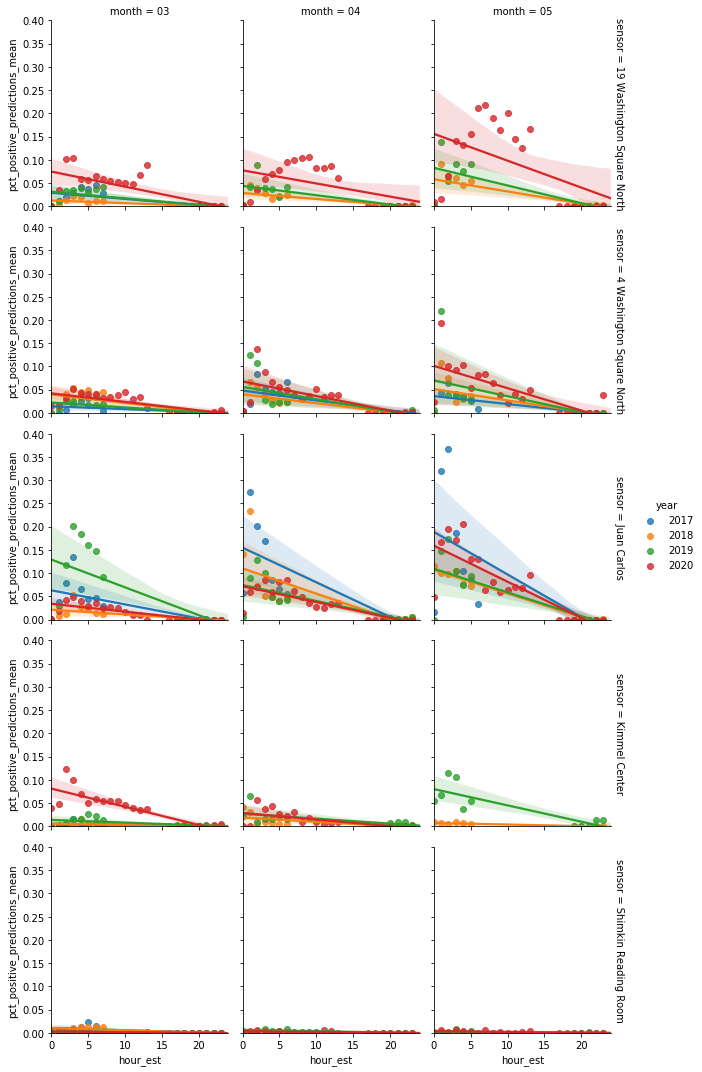

In [11]:
g = sns.FacetGrid(yamnetMonthly, row='sensor', 
                  col="month", hue='year', ylim=(0, 0.4), xlim=(0,24),
                  margin_titles=True)
g.map(sns.regplot, "hour_est", "pct_positive_predictions_mean")
g.add_legend()
g.savefig("../figures/yamnet_avg_by_hour.png")

#### Figure XX: Scatter Plot of the hour in est vs mean pct positive predictions for the hour

### 5. Looking at Correlation for `pct_positive_predictions` and `avg_mtr_#/km/h`

In [12]:
cols = ['pct_positive_predictions', 'avg_mtr_#/km/h']

dfList = dict(list(df.groupby('sonyc_sensor_name')))
for key in dfList.keys():
    dfList[key].set_index('timestamp', inplace=True)

19 Washington Square North
4 Washington Square North
Juan Carlos
Kimmel Center
Shimkin Reading Room


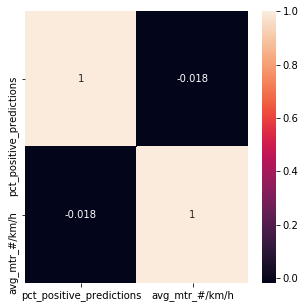

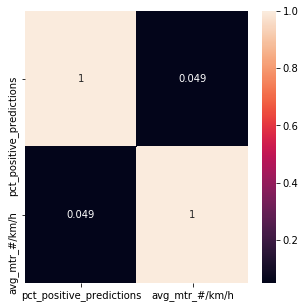

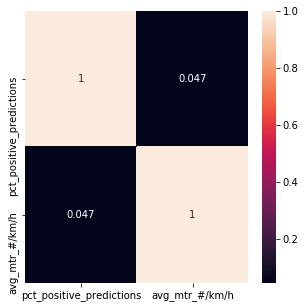

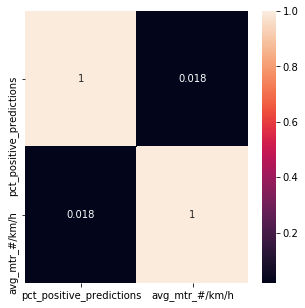

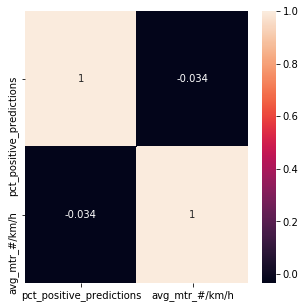

In [13]:
for key in dfList.keys():
    corrMatrix = dfList[key][cols].corr()
    plt.figure(figsize=(5,5))
    print(key)
    sns.heatmap(corrMatrix, annot=True)

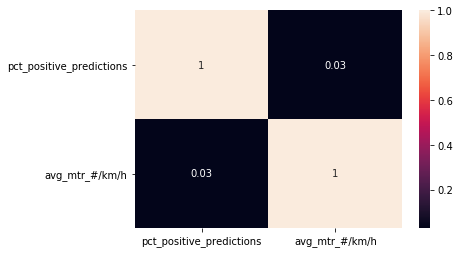

In [14]:
sns.heatmap(df[cols].corr(), annot=True)

In [15]:
df.columns

Index(['timestamp_utc', 'sonyc_sensor_id', 'sonyc_sensor_name',
       'dBAS_lin_mean', 'l1', 'l10', 'l5', 'l90',
       'count_of_positive_predictions', 'pct_positive_predictions',
       'avg_mtr_#/km/h', 'avg_mt_#/km', 'avg_height_m', 'temp_celcius',
       'dewp_celcius', 'rh_percentage', 'wind_dir', 'wind_speed_mph',
       'sea_level_pressure_mb', 'precipitation_mm', 'visibility_miles',
       'gust_mph', 'peak_wind_gust_mph', 's_19WashingtonSquareNorth',
       's_juanCarlos', 's_shimkinReadingRoom', 's_4WashingtonSquareNorth',
       's_kimmelCenter', 'timestamp', 'year', 'month', 'day', 'hour'],
      dtype='object')

In [16]:
rho = df[(df.hour >=4) & (df.hour <=8) & (df.sonyc_sensor_name!='Shimkin Reading Room')][['dBAS_lin_mean', 'l1', 'l10', 'l5', 'l90', 'count_of_positive_predictions',
   'pct_positive_predictions', 'avg_mtr_#/km/h', 'avg_mt_#/km',
   'avg_height_m', 'temp_celcius', 'dewp_celcius', 'rh_percentage',
   'wind_dir', 'wind_speed_mph', 'sea_level_pressure_mb',
   'precipitation_mm', 'visibility_miles', 'gust_mph',
   'peak_wind_gust_mph', 's_19WashingtonSquareNorth', 's_juanCarlos', 
    's_4WashingtonSquareNorth', 's_kimmelCenter']].corr()

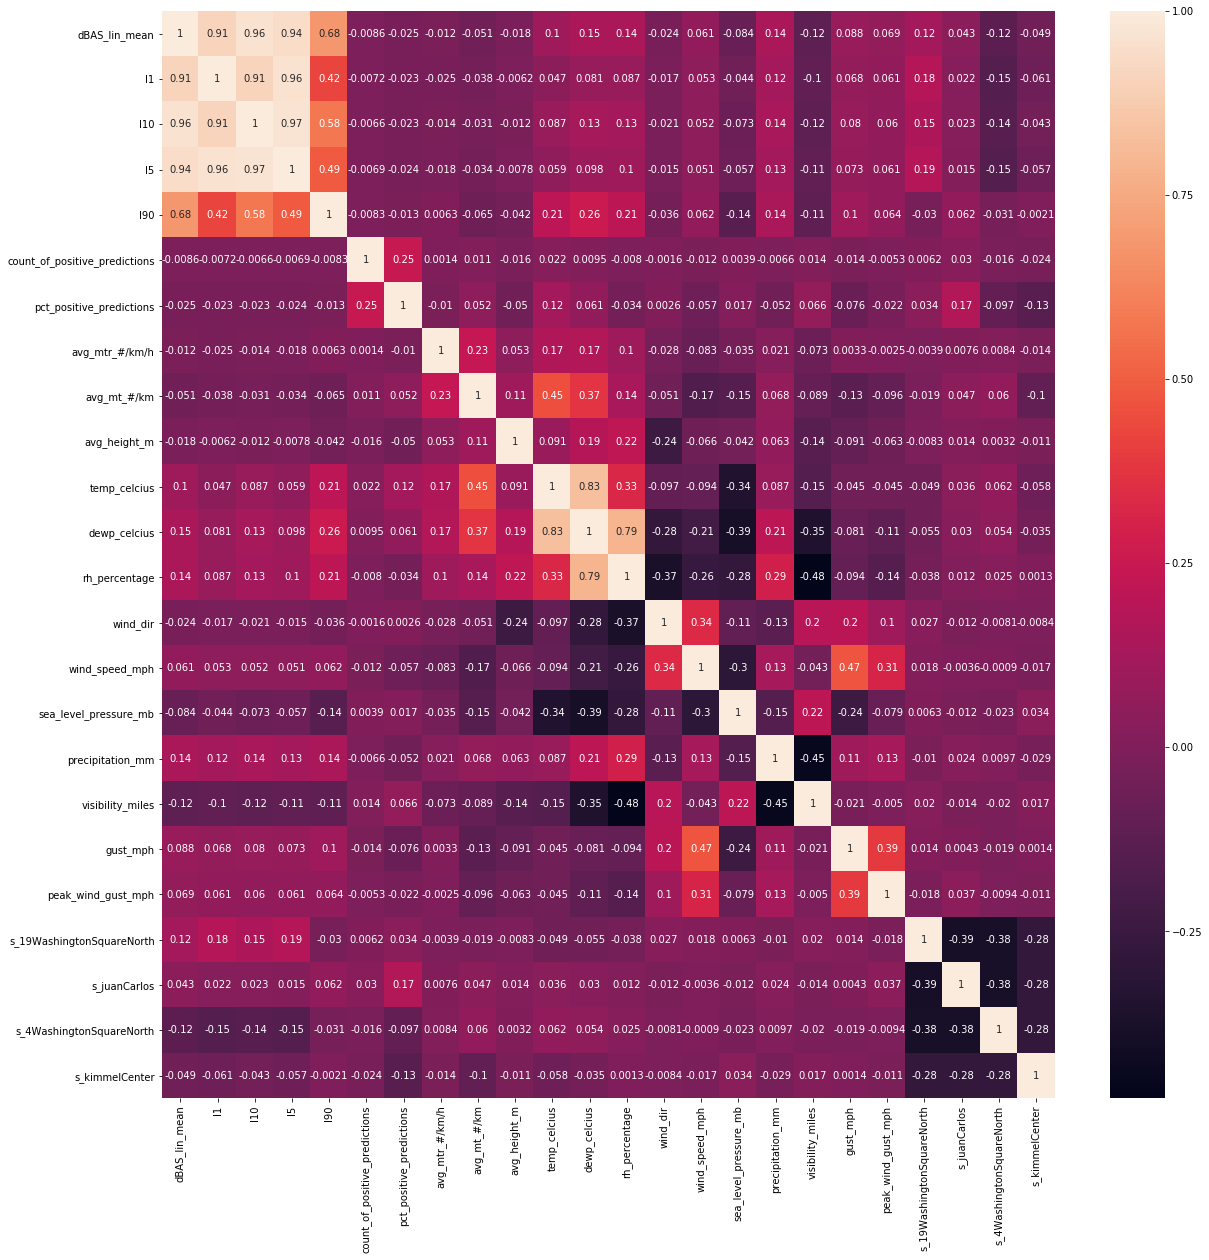

In [17]:
plt.figure(figsize=(20,20))
sns.heatmap(rho, annot=True)
plt.savefig("../figures/all_metrics_corr.png")

#### Figure XX: Correlation Matrix of the Features in Dataframe

In [18]:
pval = df[(df.hour >=4) & (df.hour <=8) & (df.sonyc_sensor_name!='Shimkin Reading Room')][['dBAS_lin_mean', 'l1', 'l10', 'l5', 'l90', 'count_of_positive_predictions',
   'pct_positive_predictions', 'avg_mtr_#/km/h', 'avg_mt_#/km',
   'avg_height_m', 'temp_celcius', 'dewp_celcius', 'rh_percentage',
   'wind_dir', 'wind_speed_mph', 'sea_level_pressure_mb',
   'precipitation_mm', 'visibility_miles', 'gust_mph',
   'peak_wind_gust_mph', 's_19WashingtonSquareNorth', 's_juanCarlos', 
    's_4WashingtonSquareNorth', 's_kimmelCenter']].corr(method=lambda x, y: stats.pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.astype(str) + p

dBAS_lin_mean  \
dBAS_lin_mean                                    1.0***   
l1                                0.9113550508092834***   
l10                               0.9631551168243381***   
l5                                0.9437393837513927***   
l90                               0.6835176836655279***   
count_of_positive_predictions  -0.008627703464604225***   
pct_positive_predictions       -0.025385584385551836***   
avg_mtr_#/km/h                 -0.011624644391000942***   
avg_mt_#/km                     -0.05121937879815299***   
avg_height_m                   -0.018305258225290853***   
temp_celcius                     0.10103310588103605***   
dewp_celcius                      0.1473328603803241***   
rh_percentage                    0.14058684430004265***   
wind_dir                        -0.02419477399815207***   
wind_speed_mph                   0.06102160135310989***   
sea_level_pressure_mb            -0.0837233353822966***   
precipitation_mm                  0.1434167206637983***   
visibility_miles                -0.11777076203398254***   
gust_mph                         0.08764244169148047***   
peak_wind_gust_mph               0.06878731114385972***   
s_19WashingtonSquareNorth        0.12132642867453267***   
s_juanCarlos                     0.04335040665454252***   
s_4WashingtonSquareNorth        -0.12463019511783702***   
s_kimmelCenter                  -0.04862138196596449***   

                                                     l1  \
dBAS_lin_mean                     0.9113550508092834***   
l1                                               1.0***   
l10                               0.9080458252416004***   
l5                                0.9648227900644649***   
l90                              0.42376543290065805***   
count_of_positive_predictions  -0.007187695915700666***   
pct_positive_predictions       -0.023311222526935304***   
avg_mtr_#/km/h                 -0.025204722768435942***   
avg_mt_#/km                     -0.03810794251035519***   
avg_height_m                    -0.006172423873116884**   
temp_celcius                    0.047470466213137795***   
dewp_celcius                     0.08075155129304425***   
rh_percentage                    0.08665559493040446***   
wind_dir                       -0.017246541928380047***   
wind_speed_mph                  0.053186418815665236***   
sea_level_pressure_mb          -0.044111682819473676***   
precipitation_mm                 0.12097614060344265***   
visibility_miles                -0.10264478656491992***   
gust_mph                           0.068441867164941***   
peak_wind_gust_mph               0.06104264766054346***   
s_19WashingtonSquareNorth         0.1774442155899837***   
s_juanCarlos                    0.022117639377644938***   
s_4WashingtonSquareNorth        -0.14915065589252696***   
s_kimmelCenter                 -0.061206244035318366***   

                                                    l10  \
dBAS_lin_mean                     0.9631551168243381***   
l1                                0.9080458252416004***   
l10                                              1.0***   
l5                                0.9672430032514734***   
l90                               0.5830995493604763***   
count_of_positive_predictions   -0.006644557955923962**   
pct_positive_predictions        -0.02342370290198309***   
avg_mtr_#/km/h                 -0.014096764480848751***   
avg_mt_#/km                    -0.031338897531442436***   
avg_height_m                   -0.012305217046817684***   
temp_celcius                     0.08707841486178894***   
dewp_celcius                     0.12999946596535267***   
rh_percentage                    0.12640893392252733***   
wind_dir                        -0.02075375760419721***   
wind_speed_mph                   0.05190904223975565***   
sea_level_pressure_mb           -0.07264102396956683***   
precipitation_mm                 0.13561224500252742***   
visibility_miles            

In [19]:
rho.pct_positive_predictions.sort_values()

s_kimmelCenter                  -0.132257
s_4WashingtonSquareNorth        -0.096817
gust_mph                        -0.075577
wind_speed_mph                  -0.056943
precipitation_mm                -0.051990
avg_height_m                    -0.049501
rh_percentage                   -0.033522
dBAS_lin_mean                   -0.025386
l5                              -0.023997
l10                             -0.023424
l1                              -0.023311
peak_wind_gust_mph              -0.021648
l90                             -0.013171
avg_mtr_#/km/h                  -0.010209
wind_dir                         0.002580
sea_level_pressure_mb            0.017027
s_19WashingtonSquareNorth        0.033866
avg_mt_#/km                      0.052217
dewp_celcius                     0.060619
visibility_miles                 0.065786
temp_celcius                     0.124600
s_juanCarlos                     0.173075
count_of_positive_predictions    0.245690
pct_positive_predictions         1

#### Correlation (rho and p-values) of the correlation table

/home/cusp/yg833/.conda/envs/birdsVE3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


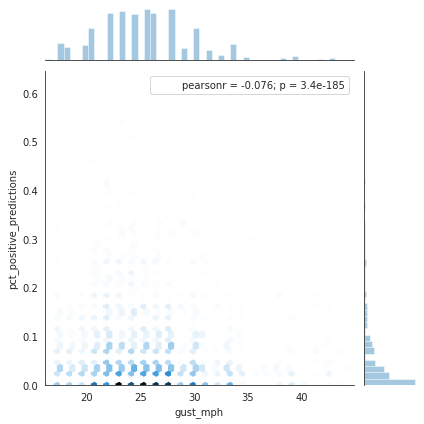

In [20]:
with sns.axes_style('white'):
    sns.jointplot("gust_mph", "pct_positive_predictions",
                  data=df[(df.hour >=4) & (df.hour <=8) & (df.sonyc_sensor_name!='Shimkin Reading Room')][['gust_mph',
                                                                                                           'pct_positive_predictions']], kind='hex').annotate(stats.pearsonr)

/home/cusp/yg833/.conda/envs/birdsVE3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


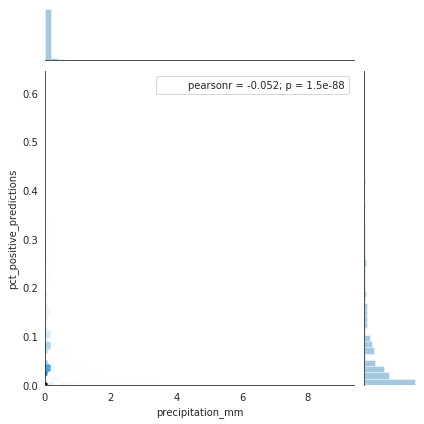

In [21]:
with sns.axes_style('white'):
    sns.jointplot("precipitation_mm", "pct_positive_predictions",
                  data=df[(df.hour >=4) & (df.hour <=8) & (df.sonyc_sensor_name!='Shimkin Reading Room')][['precipitation_mm',
                                                                                                           'pct_positive_predictions']], kind='hex').annotate(stats.pearsonr)

/home/cusp/yg833/.conda/envs/birdsVE3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


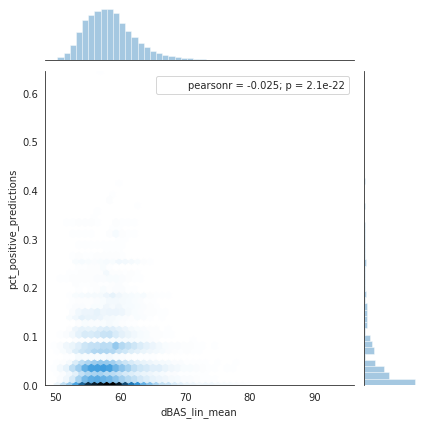

In [22]:
with sns.axes_style('white'):
    sns.jointplot("dBAS_lin_mean", "pct_positive_predictions",
                  data=df[(df.hour >=4) & (df.hour <=8) & (df.sonyc_sensor_name!='Shimkin Reading Room')][["pct_positive_predictions",
                                                                                                           'dBAS_lin_mean']], kind='hex').annotate(stats.pearsonr)

/home/cusp/yg833/.conda/envs/birdsVE3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


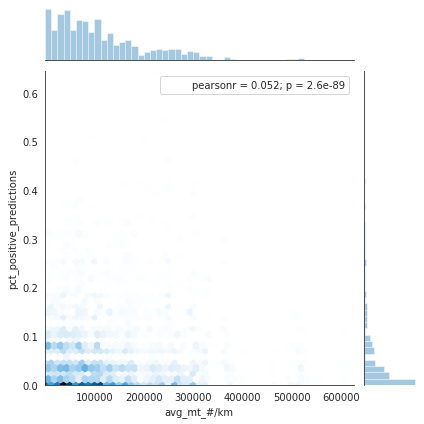

In [23]:
with sns.axes_style('white'):
    sns.jointplot("avg_mt_#/km", "pct_positive_predictions",
                  data=df[(df.hour >=4) & (df.hour <=8) & (df.sonyc_sensor_name!='Shimkin Reading Room')][["pct_positive_predictions",
                                                                                                           'avg_mt_#/km']], kind='hex').annotate(stats.pearsonr)

/home/cusp/yg833/.conda/envs/birdsVE3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


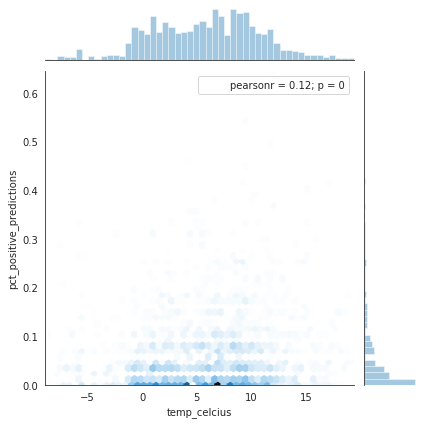

In [24]:
with sns.axes_style('white'):
    sns.jointplot("temp_celcius", "pct_positive_predictions",
                  data=df[(df.hour >=4) & (df.hour <=8) & (df.sonyc_sensor_name!='Shimkin Reading Room')][["pct_positive_predictions",
                                                                                                           'temp_celcius']], kind='hex').annotate(stats.pearsonr)

In [30]:
df[(df.hour >=4) & (df.hour <=8) & (df.sonyc_sensor_name!='Shimkin Reading Room')].hour.unique()

array([4, 5, 6, 7, 8])

### 6. Inspecting the trends in timeseries

Detrend by Differencing

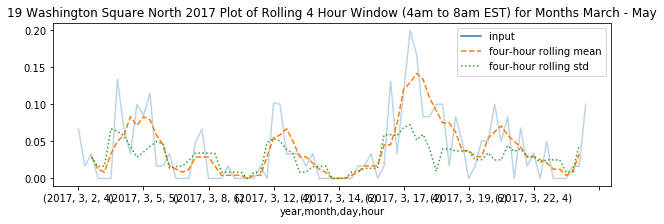

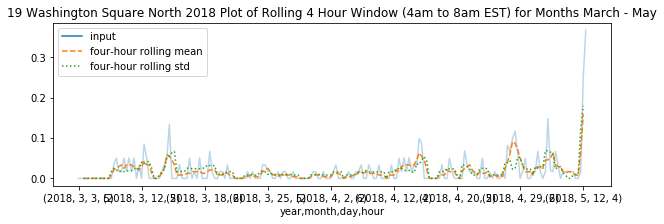

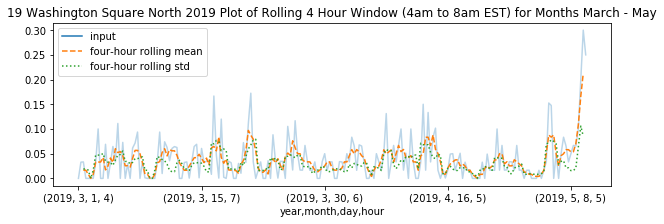

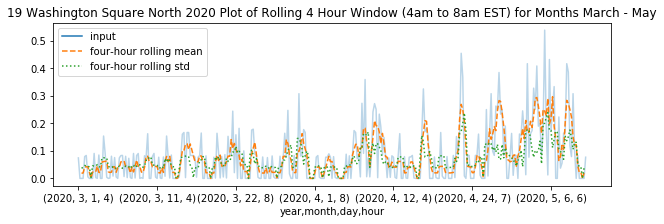

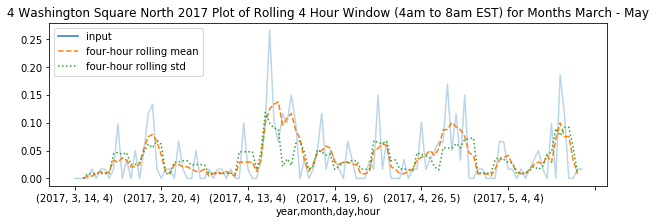

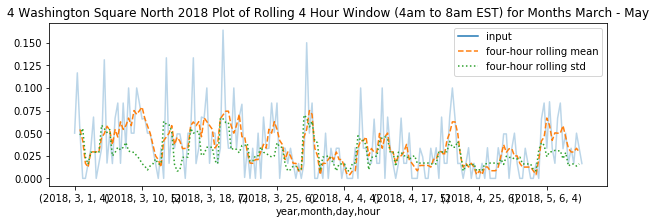

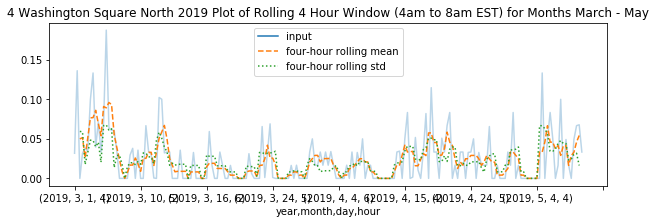

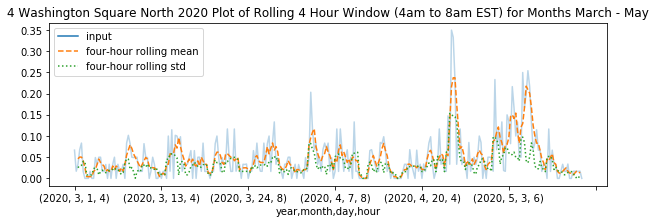

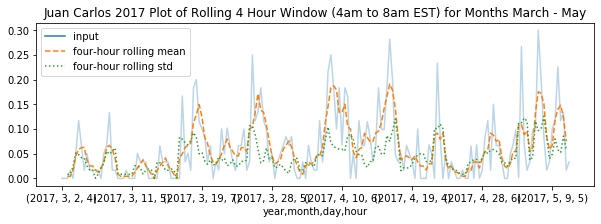

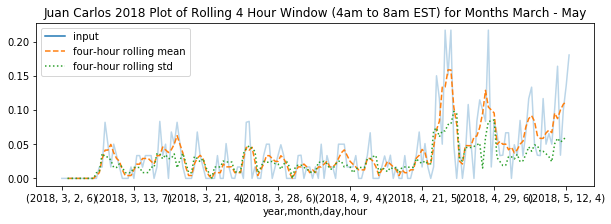

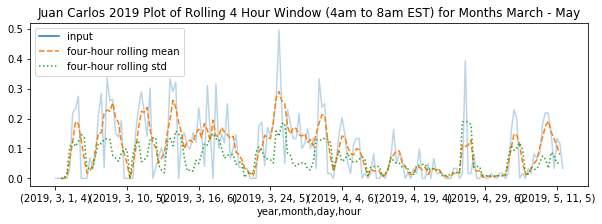

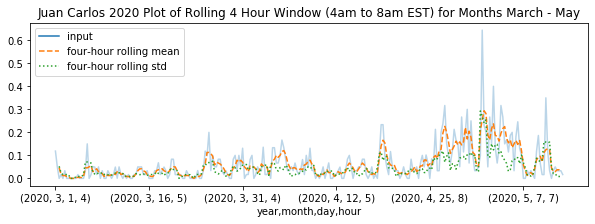

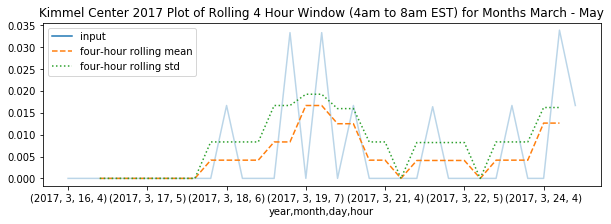

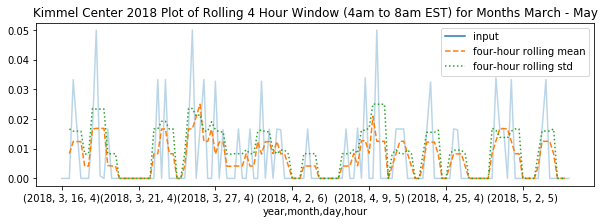

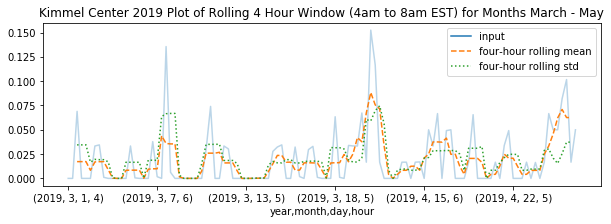

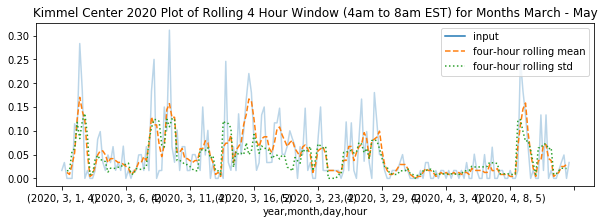

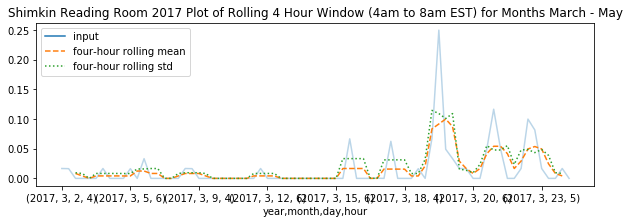

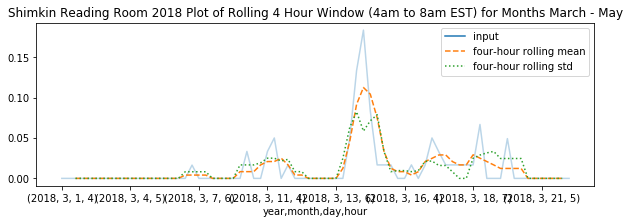

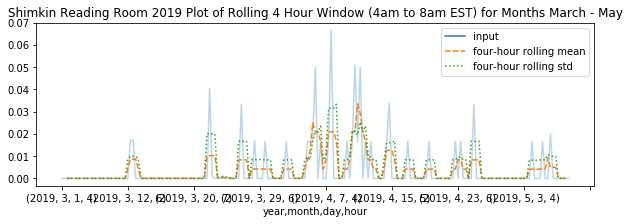

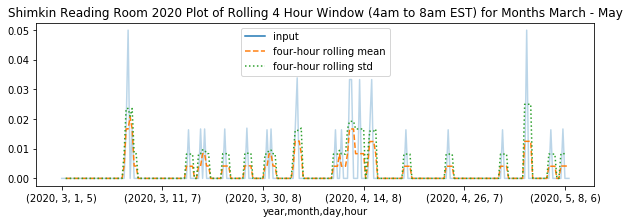

In [25]:
years = [2017, 2018, 2019, 2020]
for key in dfList:
    for y in years:
        temp = dfList[key][(dfList[key].year==y) & 
                                 (dfList[key].hour>=4) &
                                (dfList[key].hour<=8)].groupby(['year','month','day','hour']).mean()['pct_positive_predictions']
        rolling = temp.rolling(4, center=True)
        data = pd.DataFrame({'input': temp, 
                    'four-hour rolling mean':rolling.mean(), 
                    'four-hour rolling std':rolling.std()})
        ax = data.plot(style=['-', '--', ':'], figsize=(10,3))
        ax.lines[0].set_alpha(0.3)
        plt.title(key + " " + str(y) +" Plot of Rolling 4 Hour Window (4am to 8am EST) for Months March - May" )

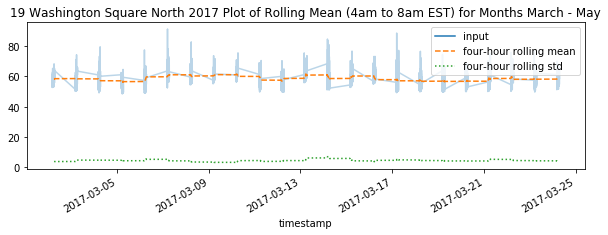

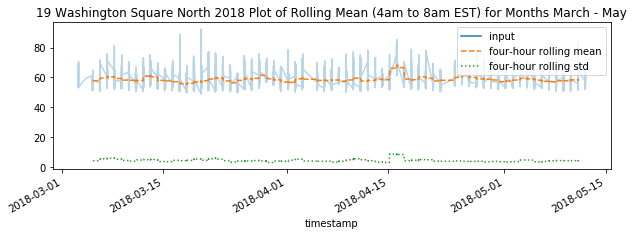

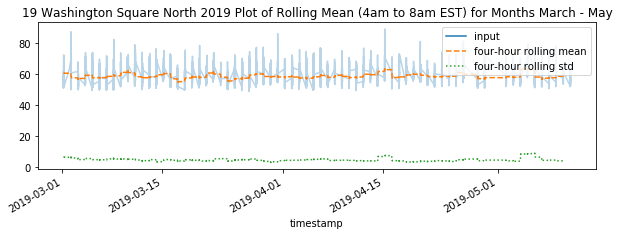

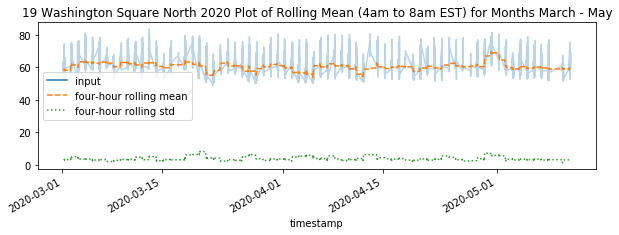

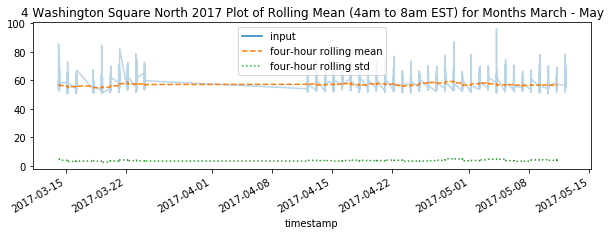

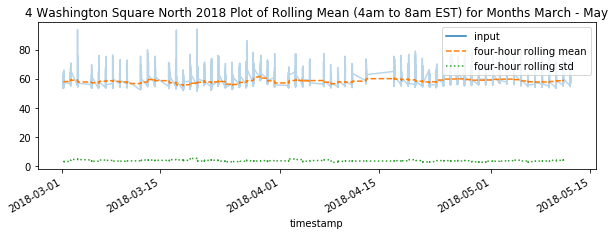

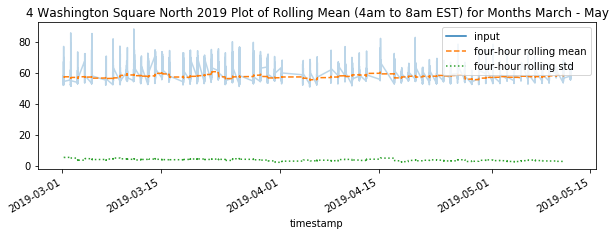

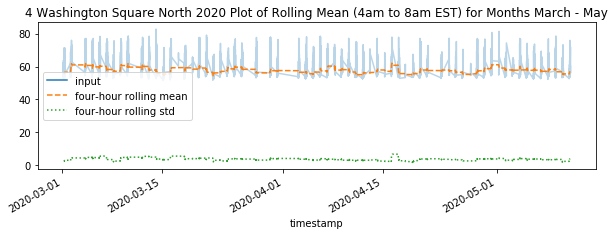

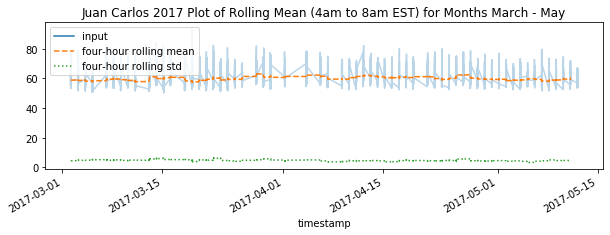

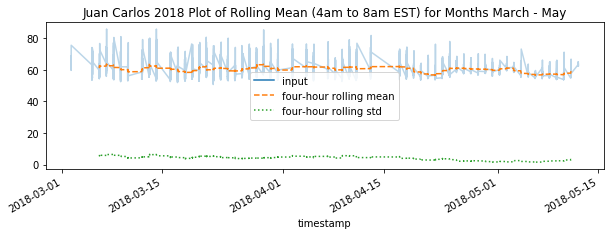

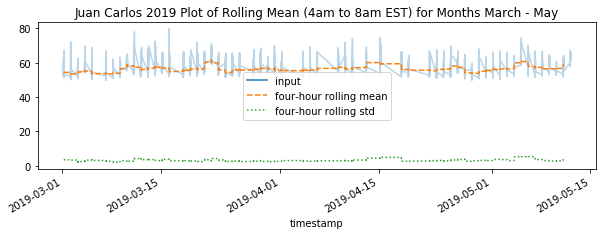

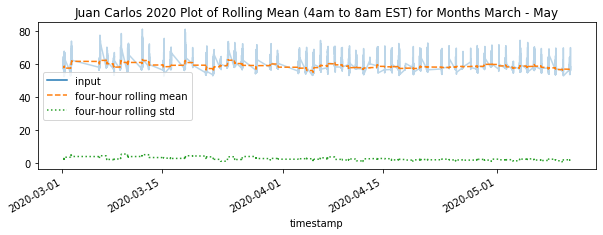

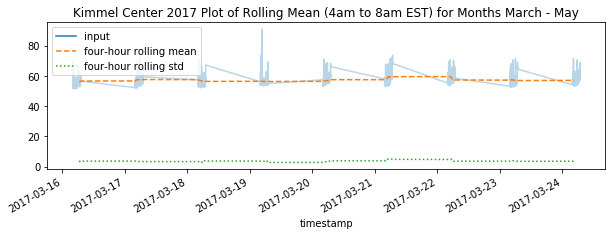

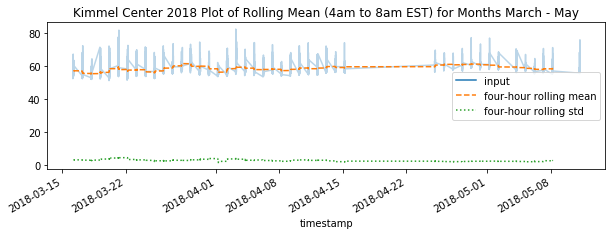

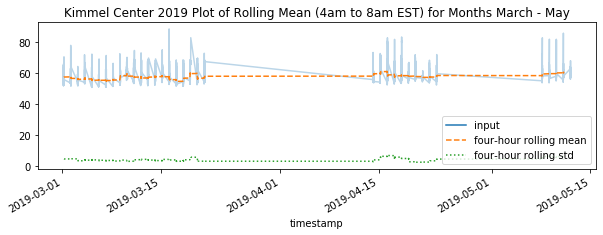

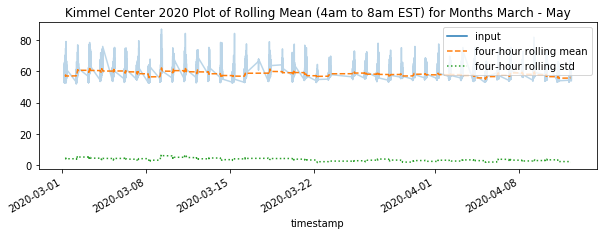

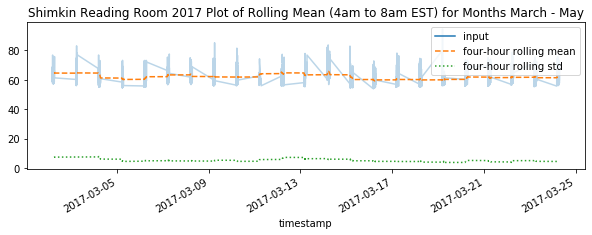

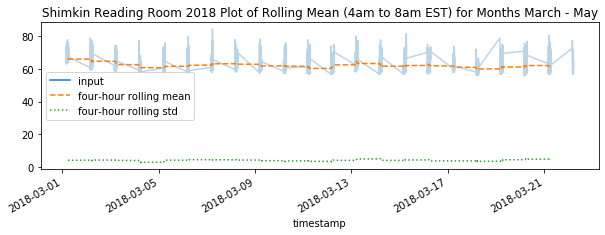

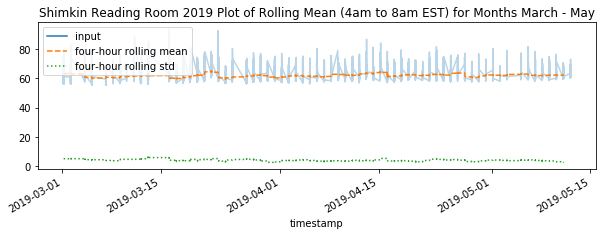

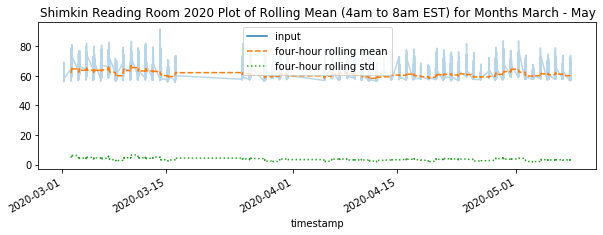

In [26]:
for key in dfList:
    for y in years:
        temp = dfList[key][(dfList[key].year==y) & (dfList[key].hour>=4) & (dfList[key].hour<=8)]['dBAS_lin_mean']
        rolling = temp.rolling(240, center=True)
        data = pd.DataFrame({'input': temp, 
                    'four-hour rolling mean':rolling.mean(), 
                    'four-hour rolling std':rolling.std()})
        ax = data.plot(style=['-', '--', ':'], figsize=(10,3))
        ax.lines[0].set_alpha(0.3)
        plt.title(key + " " + str(y) +" Plot of Rolling Mean (4am to 8am EST) for Months March - May")

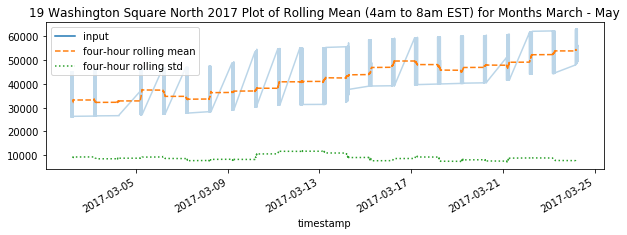

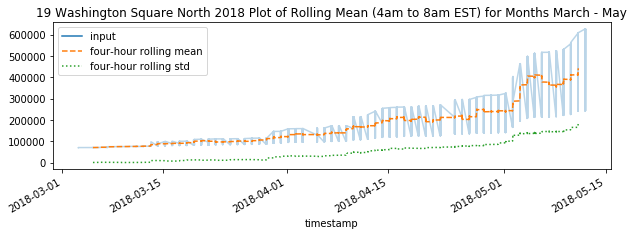

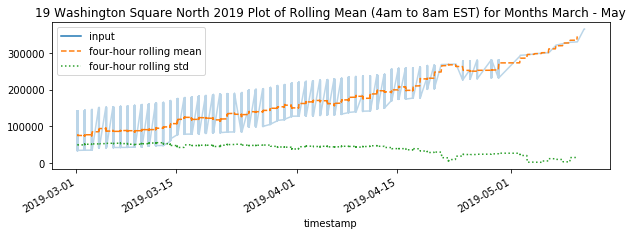

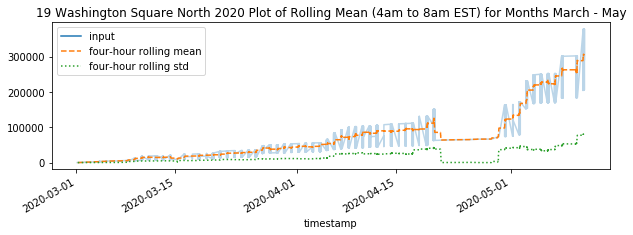

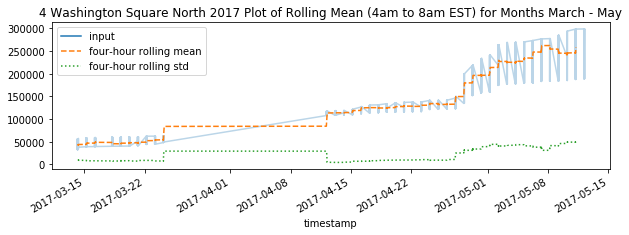

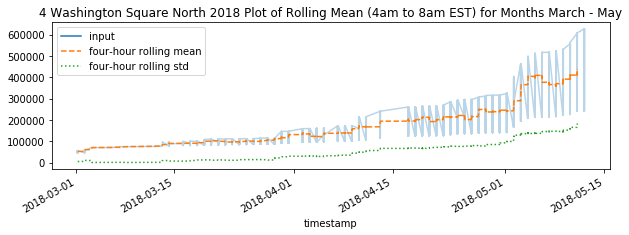

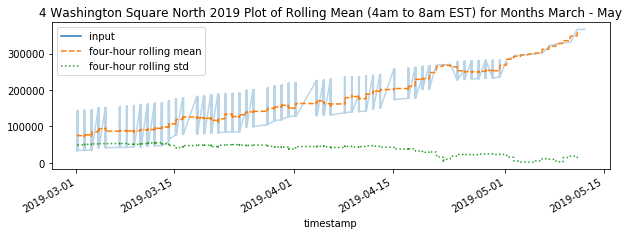

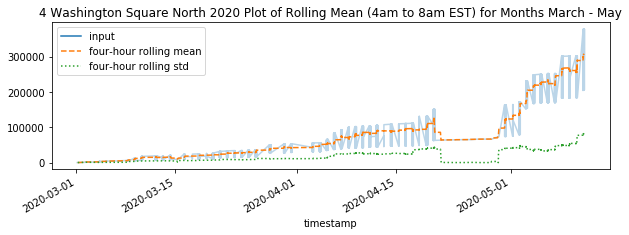

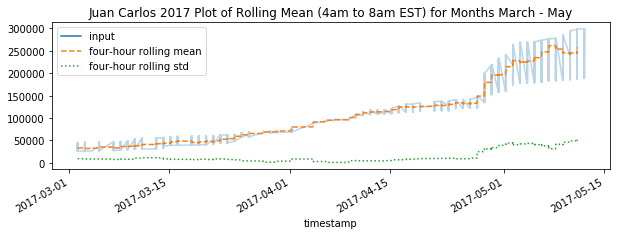

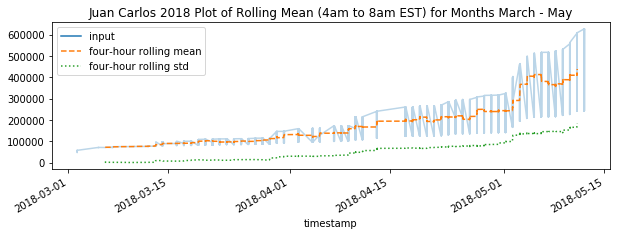

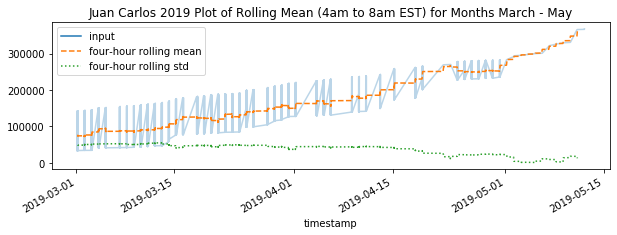

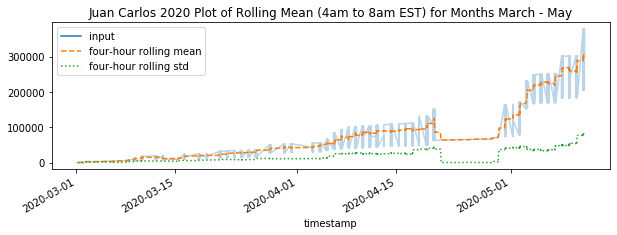

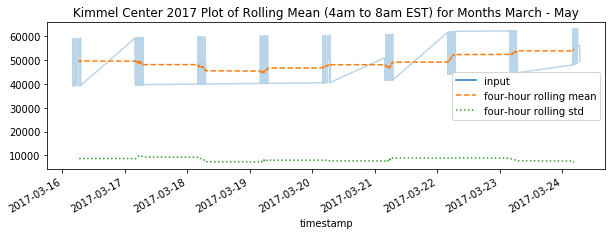

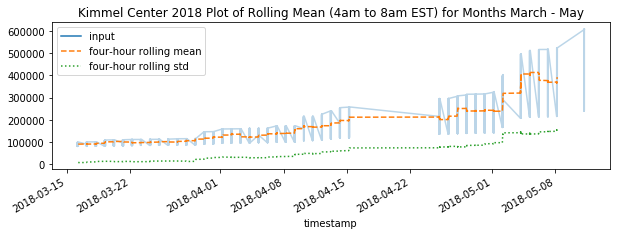

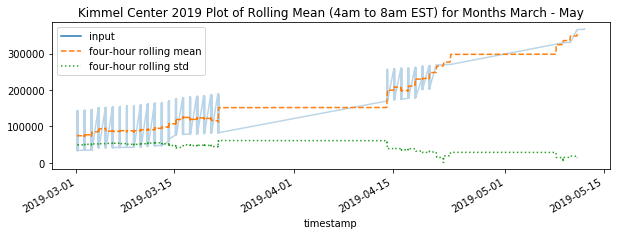

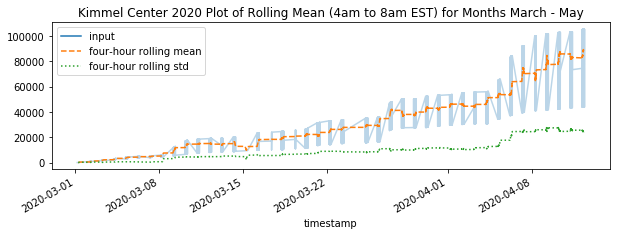

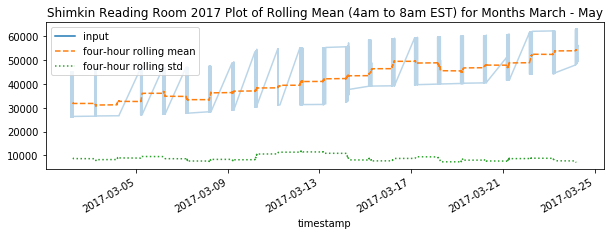

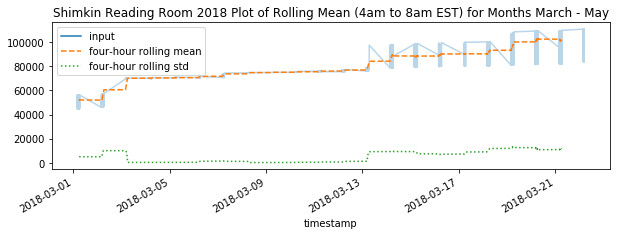

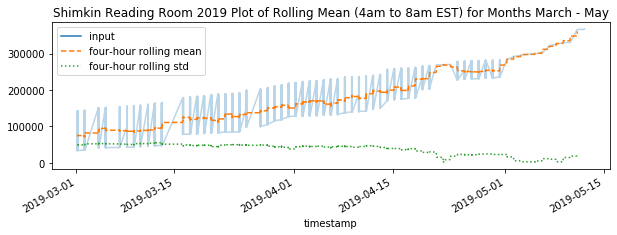

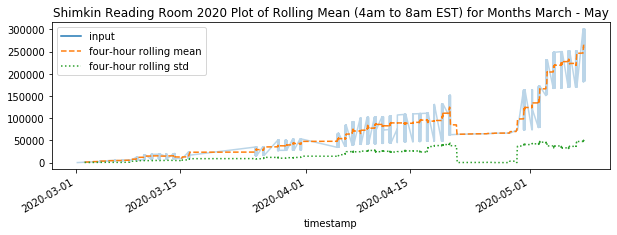

In [27]:
for key in dfList:
    for y in years:
        temp = dfList[key][(dfList[key].year==y) & (dfList[key].hour>=4) & (dfList[key].hour<=8)]['avg_mt_#/km']
        rolling = temp.rolling(240, center=True)
        data = pd.DataFrame({'input': temp, 
                    'four-hour rolling mean':rolling.mean(), 
                    'four-hour rolling std':rolling.std()})
        ax = data.plot(style=['-', '--', ':'], figsize=(10,3))
        ax.lines[0].set_alpha(0.3)
        plt.title(key + " " + str(y) +" Plot of Rolling Mean (4am to 8am EST) for Months March - May")

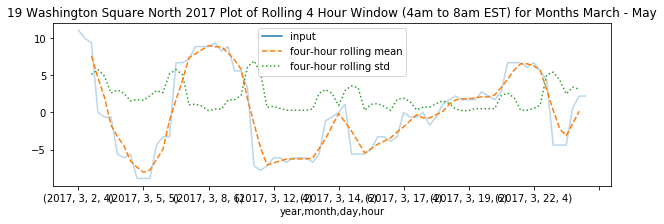

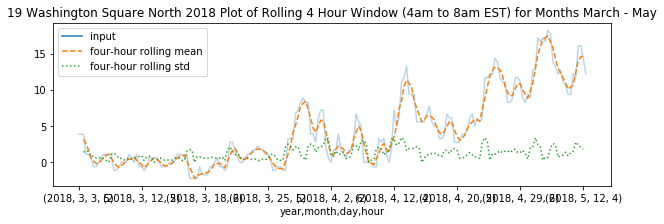

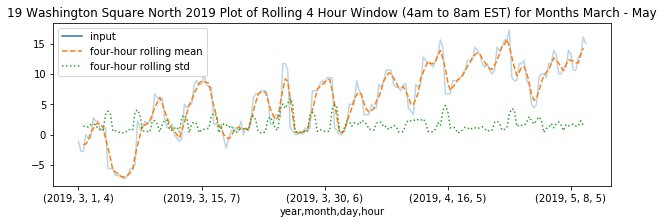

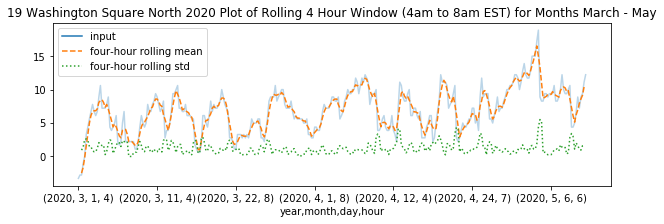

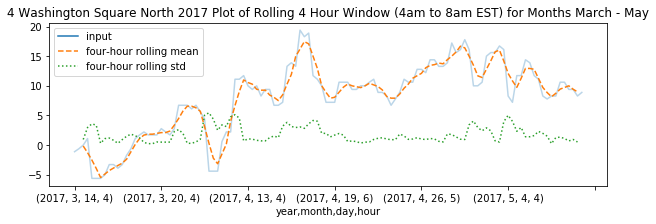

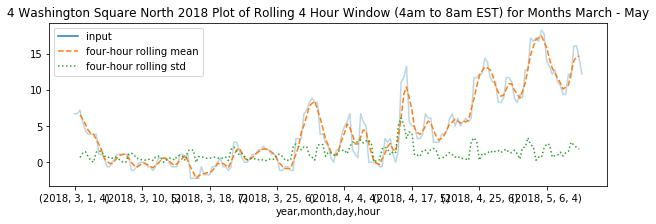

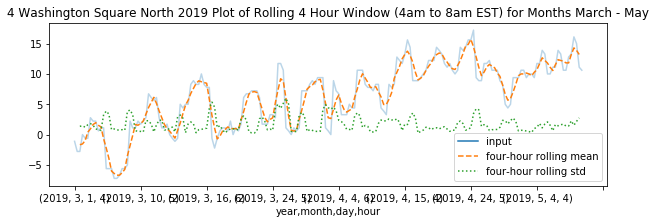

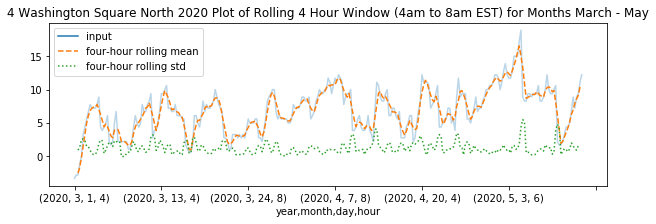

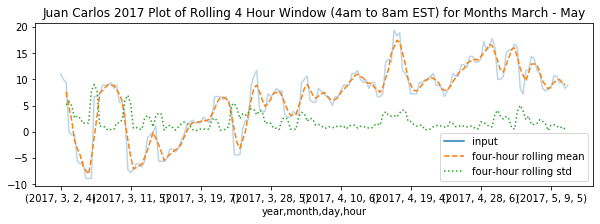

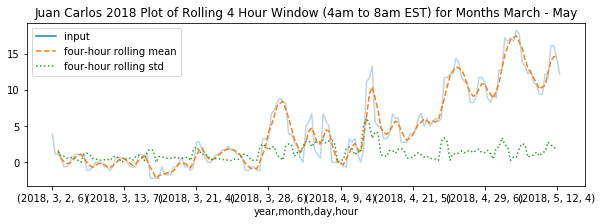

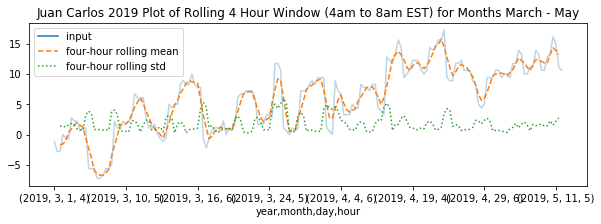

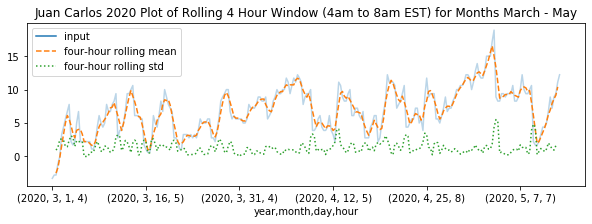

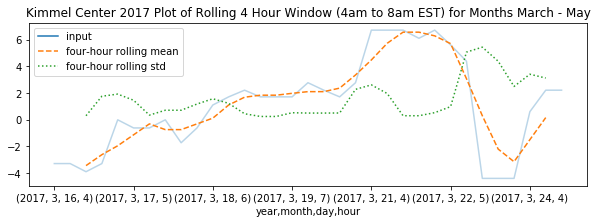

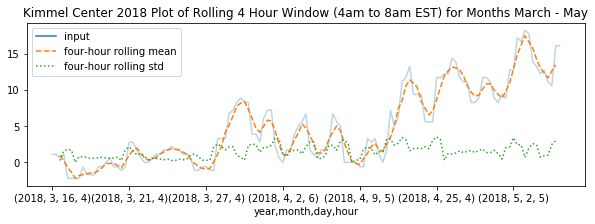

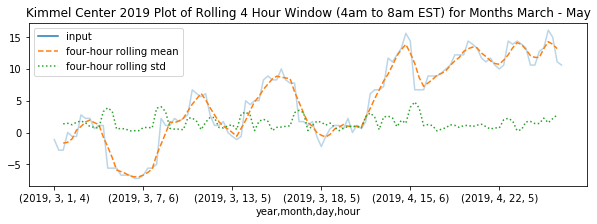

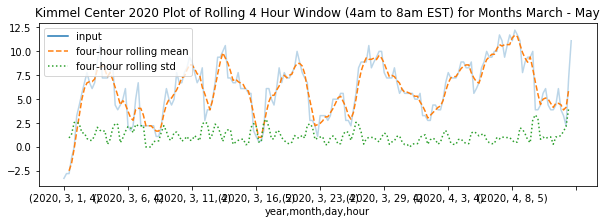

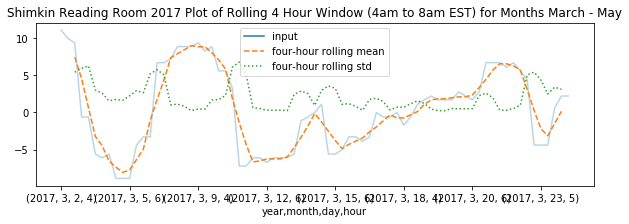

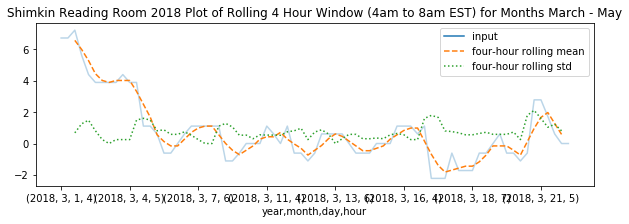

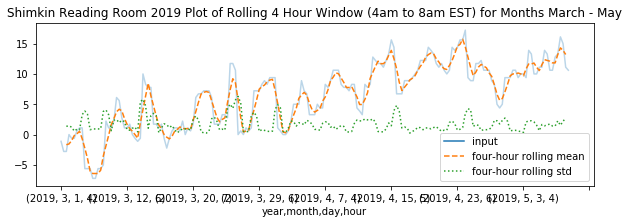

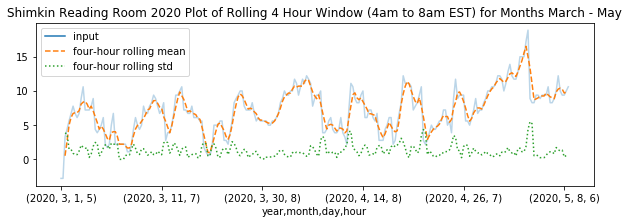

In [28]:
for key in dfList:
    for y in years:
        temp = dfList[key][(dfList[key].year==y) & 
                                 (dfList[key].hour>=4) &
                                (dfList[key].hour<=8)].groupby(['year','month','day','hour']).mean()['temp_celcius']
        rolling = temp.rolling(4, center=True)
        data = pd.DataFrame({'input': temp, 
                    'four-hour rolling mean':rolling.mean(), 
                    'four-hour rolling std':rolling.std()})
        ax = data.plot(style=['-', '--', ':'], figsize=(10,3))
        ax.lines[0].set_alpha(0.3)
        plt.title(key + " " + str(y) +" Plot of Rolling 4 Hour Window (4am to 8am EST) for Months March - May" )